In [1]:
import pandas as pd
import numpy as np
import ast
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics.pairwise import cosine_similarity
from itertools import cycle
from collections import Counter
from scipy.stats import percentileofscore
from sklearn.preprocessing import MinMaxScaler
import pycountry
import matplotlib.patches as mpatches
from matplotlib.colors import to_hex

In [2]:
plt.style.use("seaborn-colorblind")

# Data Preparation

In [3]:
clustering_df = pd.read_csv("data/track_clustering.csv", usecols=["track_id", "cluster"]).set_index("track_id")
clustering_df = clustering_df[clustering_df["cluster"] != -1]
clustering_df.head()

,cluster
track_id,
4868,1
572665,1
2897,1
15100,1
7112,1


In [4]:
beyms = pd.read_csv("data/beyms.csv")["user_id"].tolist()

In [5]:
clustered_tracks = clustering_df.index.unique().tolist()

# Calculate User-to-Cluster weights

In [6]:
events_df = pd.read_csv("data/more_specific_events.csv")
events_df = events_df[events_df["track_id"].isin(clustered_tracks)]
events_df.head()

,user_id,artist_id,album_id,track_id,timestamp
0,31435741,21,31,53,1370977938
1,31435741,21,31,53,1370977728
2,31435741,21,31,53,1370977518
3,31435741,21,31,53,1370977308
4,31435741,21,31,53,1370977098


In [7]:
events_to_cluster_df = events_df.merge(clustering_df, left_on="track_id", right_index=True)
events_to_cluster_df.head()

,user_id,artist_id,album_id,track_id,timestamp,cluster
0,31435741,21,31,53,1370977938,1
1,31435741,21,31,53,1370977728,1
2,31435741,21,31,53,1370977518,1
3,31435741,21,31,53,1370977308,1
4,31435741,21,31,53,1370977098,1


In [8]:
weights_df = events_to_cluster_df.groupby(["user_id", "cluster"]).size() / events_to_cluster_df.groupby("user_id").size()
weights_df = weights_df.reset_index()
weights_df.columns = ["user_id", "cluster", "weight"]
weights_df = weights_df.pivot(index="user_id", columns="cluster", values="weight").fillna(0)
weights_df.head()

cluster,0,1,2,3
user_id,,,,
1049656,0.064476,0.295702,0.369318,0.270504
1055118,0.051454,0.940716,0.001119,0.006711
1056935,0.105074,0.711047,0.051457,0.132422
1070023,0.028662,0.816348,0.019108,0.135881
1072752,0.294695,0.431565,0.105435,0.168304


# Calculate IDF-score of Track Clusters

In [9]:
cluster_idf_scores = np.log10(len(clustering_df) / clustering_df.groupby("cluster").size())
cluster_idf_scores

cluster
0    1.070692
1    0.187658
2    1.272729
3    0.672623
dtype: float64

# Assign Users to Track Clusters

In [10]:
user_groups = []
for user_id, weights in weights_df.iterrows():
    favorite_track_cluster = (weights * cluster_idf_scores).idxmax()
    user_groups.append((user_id, favorite_track_cluster))
user_groups_df = pd.DataFrame(user_groups, columns=["user_id", "user group"]).set_index("user_id")
user_groups_df.head()

,user group
user_id,
1049656,2
1055118,1
1056935,1
1070023,1
1072752,0


In [11]:
U1 = user_groups_df[user_groups_df["user group"] == 0].index.tolist()
U2 = user_groups_df[user_groups_df["user group"] == 1].index.tolist()
U3 = user_groups_df[user_groups_df["user group"] == 2].index.tolist()
U4 = user_groups_df[user_groups_df["user group"] == 3].index.tolist()

# Basic Statistics of User Groups

In [12]:
n_artists_U1 = events_df[events_df["user_id"].isin(U1)]["artist_id"].nunique()
n_artists_U2 = events_df[events_df["user_id"].isin(U2)]["artist_id"].nunique()
n_artists_U3 = events_df[events_df["user_id"].isin(U3)]["artist_id"].nunique()
n_artists_U4 = events_df[events_df["user_id"].isin(U4)]["artist_id"].nunique()

In [13]:
n_tracks_U1 = events_df[events_df["user_id"].isin(U1)]["track_id"].nunique()
n_tracks_U2 = events_df[events_df["user_id"].isin(U2)]["track_id"].nunique()
n_tracks_U3 = events_df[events_df["user_id"].isin(U3)]["track_id"].nunique()
n_tracks_U4 = events_df[events_df["user_id"].isin(U4)]["track_id"].nunique()

In [14]:
n_LEs_U1 = len(events_df[events_df["user_id"].isin(U1)])
n_LEs_U2 = len(events_df[events_df["user_id"].isin(U2)])
n_LEs_U3 = len(events_df[events_df["user_id"].isin(U3)])
n_LEs_U4 = len(events_df[events_df["user_id"].isin(U4)])

In [15]:
genres_in_clusters_df = pd.read_csv("data/genre_annotations.csv").merge(clustering_df, left_on="track_id", right_index=True)
genres_in_clusters_df["genres"] = genres_in_clusters_df["genres"].apply(ast.literal_eval)

n_genres_U1 = genres_in_clusters_df.groupby("cluster")["genres"].apply(chain.from_iterable).apply(set).apply(len)[0]
n_genres_U2 = genres_in_clusters_df.groupby("cluster")["genres"].apply(chain.from_iterable).apply(set).apply(len)[1]
n_genres_U3 = genres_in_clusters_df.groupby("cluster")["genres"].apply(chain.from_iterable).apply(set).apply(len)[2]
n_genres_U4 = genres_in_clusters_df.groupby("cluster")["genres"].apply(chain.from_iterable).apply(set).apply(len)[3]

In [16]:
avg_LEs_U1 = events_df[events_df["user_id"].isin(U1)].groupby("user_id").size().mean()
avg_LEs_U2 = events_df[events_df["user_id"].isin(U2)].groupby("user_id").size().mean()
avg_LEs_U3 = events_df[events_df["user_id"].isin(U3)].groupby("user_id").size().mean()
avg_LEs_U4 = events_df[events_df["user_id"].isin(U4)].groupby("user_id").size().mean()

In [17]:
avg_tracks_U1 = events_df[events_df["user_id"].isin(U1)].groupby("user_id")["track_id"].nunique().mean()
avg_tracks_U2 = events_df[events_df["user_id"].isin(U2)].groupby("user_id")["track_id"].nunique().mean()
avg_tracks_U3 = events_df[events_df["user_id"].isin(U3)].groupby("user_id")["track_id"].nunique().mean()
avg_tracks_U4 = events_df[events_df["user_id"].isin(U4)].groupby("user_id")["track_id"].nunique().mean()

In [18]:
users_df = pd.read_csv("data/LFM-1b_users.txt", sep="\t")
users_df = users_df[users_df["age"] != -1]
avg_age_U1 = users_df[users_df["user_id"].isin(U1)]["age"].mean()
avg_age_U2 = users_df[users_df["user_id"].isin(U2)]["age"].mean()
avg_age_U3 = users_df[users_df["user_id"].isin(U3)]["age"].mean()
avg_age_U4 = users_df[users_df["user_id"].isin(U4)]["age"].mean()
sd_age_U1 = users_df[users_df["user_id"].isin(U1)]["age"].std()
sd_age_U2 = users_df[users_df["user_id"].isin(U2)]["age"].std()
sd_age_U3 = users_df[users_df["user_id"].isin(U3)]["age"].std()
sd_age_U4 = users_df[users_df["user_id"].isin(U4)]["age"].std()

In [19]:
print("[Users] U_folk: %d, U_hard: %d, U_ambi: %d, U_elec: %d" % (len(U1), len(U2), len(U3), len(U4)))
print("[Artists]  U_folk: %d, U_hard: %d, U_ambi: %d, U_elec: %d"% (n_artists_U1, n_artists_U2, n_artists_U3, n_artists_U4))
print("[Tracks]  U_folk: %d, U_hard: %d, U_ambi: %d, U_elec: %d" % (n_tracks_U1, n_tracks_U2, n_tracks_U3, n_tracks_U4))
print("[LEs] U_folk: %d, U_hard: %d, U_ambi: %d, U_elec: %d" % (n_LEs_U1, n_LEs_U2, n_LEs_U3, n_LEs_U4))
print("[Genres] U_folk: %d, U_hard: %d, U_ambi: %d, U_elec: %d" % (n_genres_U1, n_genres_U2, n_genres_U3, n_genres_U4))
print("[Avg. LEs per user] U_folk: %.3f, U_hard: %.3f, U_ambi: %.3f, U_elec: %.3f" % (avg_LEs_U1, avg_LEs_U2, avg_LEs_U3, avg_LEs_U4))
print("[Avg. Tracks per user] U_folk: %.3f, U_hard: %.3f, U_ambi: %.3f, U_elec: %.3f" % (avg_tracks_U1, avg_tracks_U2, avg_tracks_U3, avg_tracks_U4))
print("[Avg. Age (Std)] U_folk: %.3f (%.3f), U_hard: %.3f (%.3f), U_ambi: %.3f (%.3f), U_elec: %.3f (%.3f)" % (avg_age_U1, sd_age_U1, avg_age_U2, sd_age_U2, avg_age_U3, sd_age_U3, avg_age_U4, sd_age_U4))

[Users] U_folk: 369, U_hard: 919, U_ambi: 143, U_elec: 642
[Artists]  U_folk: 9559, U_hard: 11966, U_ambi: 6869, U_elec: 11814
[Tracks]  U_folk: 72663, U_hard: 107952, U_ambi: 39649, U_elec: 105907
[LEs] U_folk: 702635, U_hard: 2150246, U_ambi: 224327, U_elec: 1416354
[Genres] U_folk: 811, U_hard: 1274, U_ambi: 695, U_elec: 1005
[Avg. LEs per user] U_folk: 1904.160, U_hard: 2339.767, U_ambi: 1568.720, U_elec: 2206.159
[Avg. Tracks per user] U_folk: 549.650, U_hard: 557.470, U_ambi: 473.308, U_elec: 670.402
[Avg. Age (Std)] U_folk: 27.599 (10.369), U_hard: 23.867 (8.912), U_ambi: 29.571 (14.138), U_elec: 24.639 (7.886)


# Radar plot of a Track Cluster's contribution

In [20]:
weighted_weights = []
for user_id, weights in weights_df.iterrows():
    data_dict = (weights * cluster_idf_scores).to_dict()
    data_dict["user_id"] = user_id
    weighted_weights.append(data_dict)
weighted_weights_df = pd.DataFrame.from_dict(weighted_weights, orient="columns").set_index("user_id")
weighted_weights_df.head()

,0,1,2,3
user_id,,,,
1049656,0.069034,0.055491,0.470042,0.181947
1055118,0.055092,0.176533,0.001424,0.004514
1056935,0.112502,0.133433,0.065491,0.089070
1070023,0.030689,0.153194,0.024320,0.091397
1072752,0.315528,0.080987,0.134191,0.113205


In [21]:
avg_weights_df = weighted_weights_df.merge(user_groups_df, left_index=True, right_index=True).groupby("user group").mean()
avg_weights_df

,0,1,2,3
user group,,,,
0,0.263447,0.115818,0.064586,0.057860
1,0.048659,0.160083,0.018255,0.058622
2,0.107651,0.078281,0.341494,0.143935
3,0.042252,0.100099,0.070363,0.250107


In [34]:
%matplotlib qt
angles = np.linspace(0, 2*np.pi, 4, endpoint=False)
angles = np.concatenate((angles, [angles[0]]))
sns.set(font_scale=1.6)
sns.set_style("ticks")
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
colors = ["#0072B2", "#009E73", "#D55E00", "#CC79A7"]
markers = ["o", "^", "s", "D"]
listeners = [r"$U_{folk}$", r"$U_{hard}$", r"$U_{ambi}$", r"$U_{elec}$"]
linestyles = ['-', '--', '-.', ':']
iteration_order = [2, 3, 0, 1]
for c in iteration_order:
    weights = avg_weights_df.loc[c]
    means = np.concatenate((weights.values, [weights.values[0]]))
    ax.plot(angles, means, 'o-', linewidth=2, label=listeners[c], color=colors[c], marker=markers[c])
    ax.set_thetagrids(angles * 180/np.pi, [r"$C_{folk}$", r"$C_{hard}$", r"$C_{ambi}$", r"$C_{elec}$"])
    ax.grid(True)
    ax.tick_params(pad=15)
    plt.ylim(0, 0.4)

handles, labels = ax.get_legend_handles_labels()
resorted = [(labels[iteration_order.index(c)], handles[ iteration_order.index(c)]) for c in range(4)]
labels, handles = zip(*resorted)
plt.legend(handles, labels, loc="upper left", prop={"size": 15}, bbox_to_anchor=(-0.3, 1.2))

# Correlation of Track Clusters over Listening Events

(array([0.5, 1.5, 2.5, 3.5]), <a list of 4 Text yticklabel objects>)

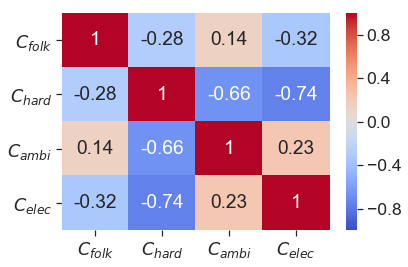

In [23]:
ax = sns.heatmap(weights_df.corr(), annot=True, vmax=1, vmin=-1, cmap="coolwarm")
plt.xlabel("")
plt.ylabel("")
ax.set_xticklabels([r"$C_{folk}$", r"$C_{hard}$", r"$C_{ambi}$", r"$C_{elec}$"])
ax.set_yticklabels([r"$C_{folk}$", r"$C_{hard}$", r"$C_{ambi}$", r"$C_{elec}$"])
plt.yticks(rotation=0)

# Average Pairwise User Similarity

In [24]:
ms = pd.read_csv("data/ms.csv", squeeze=True).tolist()

In [25]:
events_df = pd.read_csv("data/events.csv")
events_df = events_df[events_df["track_id"].isin(clustered_tracks)]

In [26]:
genre_annotations_df = pd.read_csv("data/genre_annotations.csv").set_index("track_id")
genre_annotations_df.head()

,genres
track_id,
11393952,"['electronic', 'pop', 'indiepop', 'rock', 'sin..."
4868,"['soul', 'pop', 'singersongwriter', 'blues', '..."
2900,"['electronic', 'indiepop', 'shoegaze', 'dreamp..."
2498,"['pop', 'soul', 'indiepop', 'chamberpop', 'tri..."
26142,"['pop', 'indiepop', 'rock', 'alternativerock',..."


In [27]:
genres_per_event_df = events_df.merge(genre_annotations_df, left_on="track_id", right_on="track_id")
genres_per_event_df["genres"] = genres_per_event_df["genres"].apply(ast.literal_eval).apply(Counter)
user_genre_LEs = genres_per_event_df.groupby("user_id")["genres"].sum()
user_genre_LEs.head()

user_id
1002693    {'rock': 1518, 'alternativerock': 746, 'metal'...
1004064    {'alternativerock': 1326, 'rock': 3150, 'hardr...
1021445    {'rock': 840, 'hardrock': 332, 'alternativeroc...
1039205    {'pop': 2176, 'rock': 1939, 'poprock': 1756, '...
1044661    {'electronic': 1043, 'synthpop': 281, 'pop': 4...
Name: genres, dtype: object

In [28]:
genre_representations = []
for user_id, genres_counts in user_genre_LEs.iteritems():
    data_dict = dict(genres_counts)
    data_dict["user_id"] = user_id
    
    if user_id in beyms:
        data_dict["user group"] = user_groups_df.loc[user_id]["user group"]
    else:
        data_dict["user group"] = np.nan
        
    data_dict["ms group"] = user_id in ms
    genre_representations.append(data_dict)
genre_representations_df = pd.DataFrame(genre_representations).fillna(0).set_index("user_id")
genre_representations_df.head()

,abstract,abstractbeats,abstracthiphop,abstractidm,acappella,accordeon,accordion,acidhouse,acididm,acidjazz,...,worship,wrestling,wrock,yachtrock,yeye,zeuhl,zolo,zouglou,zouk,zydeco
user_id,,,,,,,,,,,,,,,,,,,,,
1002693,15.0,1.0,2.0,0.0,6.0,0.0,12.0,0.0,0.0,7.0,...,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
1004064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,...,1.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1021445,0.0,0.0,0.0,0.0,1.0,0.0,5.0,2.0,0.0,0.0,...,3.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1039205,2.0,0.0,0.0,0.0,1.0,0.0,8.0,0.0,0.0,46.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1044661,29.0,0.0,63.0,0.0,6.0,0.0,1.0,4.0,0.0,18.0,...,4.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [29]:
def compute_sim_and_var(groupby):
    var = dict()
    sims_df = pd.DataFrame()
    for group, data in groupby:
        relevant_columns = set(data.columns).difference(["user group", "ms group"])
        
        sims = cosine_similarity(data[relevant_columns], data[relevant_columns])
        var[group] = np.var(sims)
        
        avg_sim = np.mean(sims, axis=0)

        new_row = pd.DataFrame(data={"similarity":avg_sim, "group": [group] * len(avg_sim)})
        sims_df = sims_df.append(new_row)
    return sims_df, var

In [30]:
similarity_usergroup_df, variance_usergroup = compute_sim_and_var(genre_representations_df.groupby("user group"))
similarity_msgroup_df, variance_msgroup = compute_sim_and_var(genre_representations_df.groupby("ms group"))

In [33]:
def zip_longest_cycle(A, B):
    zip_list = zip(A, cycle(B)) if len(A) > len(B) else zip(cycle(A), B)
    return zip_list

In [34]:
colors = ["#0072B2", "#009E73", "#D55E00", "#CC79A7", "#ca9161", "#ece133"]
sns.set_palette(sns.color_palette(colors))

Text(0.5, 0, '')

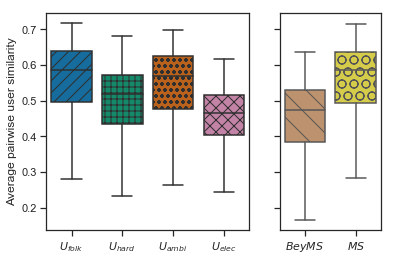

In [44]:
sns.set_style("ticks")
fig, (ax_groups, ax_all) = plt.subplots(ncols=2, sharey=True, gridspec_kw={"width_ratios": (4/6, 2/6)})
sns.set_context(font_scale=1)
sns.set_context("notebook")

g = sns.boxplot(data=similarity_usergroup_df, x="group", y="similarity", ax=ax_groups, orient="v", showfliers=False)
g_ = sns.boxplot(data=similarity_msgroup_df, x="group", y="similarity", ax=ax_all, orient="v", showfliers=False, palette=["#ca9161", "#ece133"])

patterns = ["//", "++", "oo", "xx"]
for hatch, patch in zip_longest_cycle(patterns, g.artists):
    patch.set_hatch(hatch)
    
patterns = ["\\", "O"]
for hatch, patch in zip_longest_cycle(patterns, g_.artists):
    patch.set_hatch(hatch)
    

ax_groups.set_ylabel("Average pairwise user similarity")
ax_groups.set_xticklabels([r"$U_{folk}$", r"$U_{hard}$", r"$U_{ambi}$", r"$U_{elec}$"])
ax_all.set_xticklabels([r"$BeyMS$", r"$MS$"])
ax_all.set_ylabel("")
ax_all.set_xlabel("")
ax_groups.grid(False)
ax_all.grid(False)
ax_groups.set_xlabel("")

In [49]:
%matplotlib qt
sns.set_style("ticks")
sns.set_context(font_scale=1)
sns.set_context("notebook")

g = sns.boxplot(data=similarity_usergroup_df, x="group", y="similarity", orient="v", showfliers=False)
patterns = ["//", "++", "oo", "xx"]
for hatch, patch in zip_longest_cycle(patterns, g.artists):
    patch.set_hatch(hatch)

g.set_ylabel("Average pairwise user similarity")
g.set_xticklabels([r"$U_{folk}$", r"$U_{hard}$", r"$U_{ambi}$", r"$U_{elec}$"])
g.grid(False)
g.set_xlabel("")

Text(0.5, 0, '')

In [ ]:
print("[Variances] U1: %.3f, U2: %.3f, U3: %.3f, U4: %.3f" % (variance_usergroup[0], variance_usergroup[1], variance_usergroup[2], variance_usergroup[3]))
print("[Variances] BeyMS: %.3f, MS: %.3f" % (variance_msgroup[0], variance_msgroup[1]))

# Calculate Top Countries per Group

In [28]:
users_df = pd.read_csv("data/LFM-1b_users.txt", sep="\t")[["user_id", "country"]].dropna().set_index("user_id")
users_df.head()

,country
user_id,
384,UK
3653,UK
4813,US
5069,AT
5213,UK


In [29]:
users_df.loc[U1]["country"].value_counts(ascending=False).head(10).index.tolist()

['US', 'DE', 'BR', 'UK', 'RU', 'PL', 'ES', 'NL', 'AU', 'FR']

In [30]:
users_df.loc[U2]["country"].value_counts(ascending=False).head(10).index.tolist()

['US', 'DE', 'BR', 'RU', 'UK', 'PL', 'AU', 'FI', 'ES', 'JP']

In [31]:
users_df.loc[U3]["country"].value_counts(ascending=False).head(10).index.tolist()

['US', 'RU', 'UK', 'DE', 'TR', 'PL', 'JP', 'NL', 'IT', 'IR']

In [32]:
users_df.loc[U4]["country"].value_counts(ascending=False).head(10).index.tolist()

['US', 'RU', 'DE', 'UK', 'PL', 'UA', 'BR', 'CA', 'FI', 'IT']

In [33]:
users_df.loc[beyms]["country"].value_counts(ascending=False).head(10).index.tolist()

['US', 'RU', 'DE', 'UK', 'BR', 'PL', 'AU', 'FI', 'ES', 'NL']

In [34]:
users_df.loc[ms]["country"].value_counts(ascending=False).head(10).index.tolist()

['US', 'RU', 'UK', 'PL', 'BR', 'DE', 'NL', 'UA', 'SE', 'FI']

In [35]:
users_df.loc[beyms+ms]["country"].value_counts(ascending=False).head(10).index.tolist()

['US', 'RU', 'UK', 'DE', 'PL', 'BR', 'NL', 'FI', 'AU', 'UA']

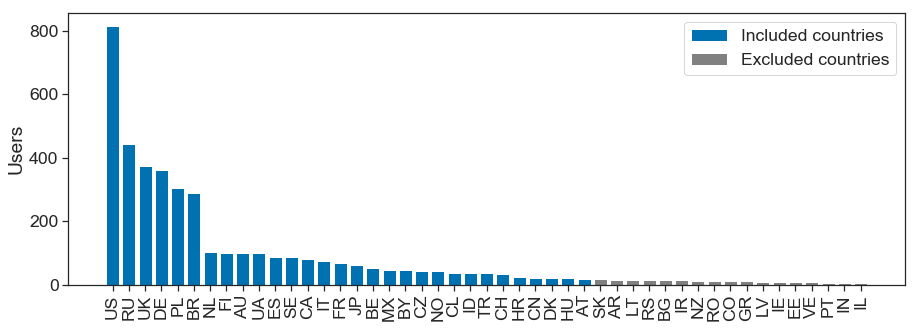

In [36]:
sns.set_style("ticks")
COUNTRY_THRESH = 20
country_counts = users_df.loc[beyms+ms]["country"].value_counts()
plt.figure(figsize=(15, 5))
plt.bar(country_counts[country_counts >= COUNTRY_THRESH].index, country_counts[country_counts >= COUNTRY_THRESH], label="Included countries")
plt.bar(country_counts[country_counts < COUNTRY_THRESH].index, country_counts[country_counts < COUNTRY_THRESH], color="grey", label="Excluded countries")
plt.legend()
plt.ylabel("Users")
plt.xticks(rotation="vertical");

In [37]:
excluded_countries = percentileofscore(country_counts, score=COUNTRY_THRESH)
included_users = users_df.loc[beyms+ms]["country"].value_counts()[users_df.loc[beyms+ms]["country"].value_counts() >= COUNTRY_THRESH].sum() / (len(beyms) + len(ms))
print("Investigating only countries with more than %d users excludes approx. %.2f%% of countries and %.2f%% of users" % (COUNTRY_THRESH, excluded_countries, 1-included_users))

Investigating only countries with more than 20 users excludes approx. 38.30% of countries and 0.05% of users


In [38]:
relevant_countries = country_counts[country_counts >= 20].index.tolist()
print("We finally obtain %d countries" % len(relevant_countries))

We finally obtain 30 countries


In [70]:
%matplotlib qt
frac_beyms = (users_df.loc[beyms]["country"].value_counts() / users_df.loc[ms+beyms]["country"].value_counts()).loc[relevant_countries]
frac_beyms.sort_values(ascending=False, inplace=True)

frac_ms = (users_df.loc[ms]["country"].value_counts() / users_df.loc[ms+beyms]["country"].value_counts()).loc[relevant_countries]
frac_ms = frac_ms.loc[frac_beyms.index]

names = frac_ms.index.tolist()
bars = range(len(relevant_countries))
barWidth = 0.75
patterns = ["\\", "O"]

plt.bar(bars, frac_beyms, bottom=frac_ms, width=barWidth, color="#ca9161", label=r"$BeyMS$", hatch="\\", edgecolor="black")
plt.bar(bars, frac_ms, width=barWidth, color="#ece133", label=r"$MS$", hatch="O", edgecolor="black")
plt.xticks(bars, names, rotation="vertical");
plt.ylabel(r"Share of $BeyMS$")
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)

In [40]:
country_counts_U1 = users_df.loc[U1][users_df.loc[U1]["country"].isin(relevant_countries)]["country"].value_counts()
country_counts_U2 = users_df.loc[U2][users_df.loc[U2]["country"].isin(relevant_countries)]["country"].value_counts()
country_counts_U3 = users_df.loc[U3][users_df.loc[U3]["country"].isin(relevant_countries)]["country"].value_counts()
country_counts_U4 = users_df.loc[U4][users_df.loc[U4]["country"].isin(relevant_countries)]["country"].value_counts()
country_counts_beyms = users_df.loc[beyms][users_df.loc[beyms]["country"].isin(relevant_countries)]["country"].value_counts()
country_counts_ms = users_df.loc[ms][users_df.loc[ms]["country"].isin(relevant_countries)]["country"].value_counts()
country_counts_all = users_df.loc[beyms+ms][users_df.loc[beyms+ms]["country"].isin(relevant_countries)]["country"].value_counts()

In [41]:
print("[Users] U_1: %d, U_2: %d, U_3: %d, U_4: %d, beyms: %d, ms: %d, all: %d" % (users_df.loc[U1]["country"].value_counts().sum(), users_df.loc[U2]["country"].value_counts().sum(), users_df.loc[U3]["country"].value_counts().sum(), users_df.loc[U4]["country"].value_counts().sum(), users_df.loc[beyms]["country"].value_counts().sum(), users_df.loc[ms]["country"].value_counts().sum(), users_df.loc[beyms+ms]["country"].value_counts().sum()))
print("[Countries] U_1: %d, U_2: %d, U_3: %d, U_4: %d, beyms: %d, ms: %d, all: %d" % (len(users_df.loc[U1]["country"].value_counts()), len(users_df.loc[U2]["country"].value_counts()), len(users_df.loc[U3]["country"].value_counts()), len(users_df.loc[U4]["country"].value_counts()), len(users_df.loc[beyms]["country"].value_counts()), len(users_df.loc[ms]["country"].value_counts()), len(users_df.loc[beyms+ms]["country"].value_counts())))

[Users] U_1: 369, U_2: 919, U_3: 143, U_4: 642, beyms: 2074, ms: 2074, all: 4148
[Countries] U_1: 41, U_2: 45, U_3: 27, U_4: 44, beyms: 47, ms: 47, all: 47


In [42]:
print("[Users in rel. Countries] U_1: %d, U_2: %d, U_3: %d, U_4: %d, beyms: %d, ms: %d, all: %d" % (country_counts_U1.sum(), country_counts_U2.sum(), country_counts_U3.sum(), country_counts_U4.sum(), country_counts_beyms.sum(), country_counts_ms.sum(), country_counts_all.sum()))
print("[rel. Countries] U_1: %d, U_2: %d, U_3: %d, U_4: %d, beyms: %d, ms: %d, all: %d" % (len(country_counts_U1), len(country_counts_U2), len(country_counts_U3), len(country_counts_U4), len(country_counts_beyms), len(country_counts_ms), len(country_counts_all)))

[Users in rel. Countries] U_1: 353, U_2: 885, U_3: 136, U_4: 612, beyms: 1987, ms: 1959, all: 3946
[rel. Countries] U_1: 30, U_2: 30, U_3: 23, U_4: 30, beyms: 30, ms: 30, all: 30


In [43]:
country_counts_U1.head(10).index.tolist()

['US', 'DE', 'BR', 'UK', 'RU', 'PL', 'ES', 'NL', 'AU', 'CA']

In [44]:
country_counts_U2.head(10).index.tolist()

['US', 'DE', 'BR', 'RU', 'UK', 'PL', 'AU', 'FI', 'ES', 'JP']

In [45]:
country_counts_U3.head(10).index.tolist()

['US', 'RU', 'UK', 'DE', 'PL', 'TR', 'JP', 'IT', 'NL', 'SE']

In [46]:
country_counts_U4.head(10).index.tolist()

['US', 'RU', 'DE', 'UK', 'PL', 'UA', 'BR', 'CA', 'FI', 'SE']

In [47]:
country_counts_beyms.head(10).index.tolist()

['US', 'RU', 'DE', 'UK', 'BR', 'PL', 'AU', 'FI', 'ES', 'NL']

In [48]:
country_counts_ms.head(10).index.tolist()

['US', 'RU', 'UK', 'PL', 'BR', 'DE', 'NL', 'UA', 'SE', 'FI']

In [49]:
country_counts_all.head(10).index.tolist()

['US', 'RU', 'UK', 'DE', 'PL', 'BR', 'NL', 'FI', 'AU', 'UA']

In [50]:
top_countries_U1 = (country_counts_U1 / country_counts_all).sort_values(ascending=False).head(10).index.tolist()
top_countries_U1

['DK', 'TR', 'ES', 'CZ', 'CH', 'NO', 'ID', 'FR', 'CA', 'NL']

In [51]:
top_countries_U2 = (country_counts_U2 / country_counts_all).sort_values(ascending=False).head(10).index.tolist()
top_countries_U2

['BR', 'AU', 'ID', 'DE', 'CN', 'JP', 'CZ', 'BY', 'MX', 'FI']

In [52]:
top_countries_U3 = (country_counts_U3 / country_counts_all).sort_values(ascending=False).head(10).index.tolist()
top_countries_U3

['TR', 'CN', 'JP', 'RU', 'BE', 'IT', 'ID', 'AT', 'HU', 'NO']

In [53]:
top_countries_U4 = (country_counts_U4 / country_counts_all).sort_values(ascending=False).head(10).index.tolist()
top_countries_U4

['AT', 'CN', 'UA', 'CA', 'MX', 'RU', 'HU', 'FI', 'CZ', 'DE']

In [54]:
top_countries_beyms = (country_counts_beyms / country_counts_all).sort_values(ascending=False).head(10).index.tolist()
top_countries_beyms

['CN', 'AT', 'CZ', 'ID', 'DE', 'HU', 'FR', 'JP', 'MX', 'ES']

In [55]:
top_countries_ms = (country_counts_ms / country_counts_all).sort_values(ascending=False).head(10).index.tolist()
top_countries_ms

['HR', 'BE', 'SE', 'NO', 'NL', 'UA', 'PL', 'CL', 'UK', 'DK']

In [56]:
U1_in_top_countries = users_df.loc[U1][users_df.loc[U1]["country"].isin(top_countries_U1)].index.tolist()
U2_in_top_countries = users_df.loc[U2][users_df.loc[U2]["country"].isin(top_countries_U2)].index.tolist()
U3_in_top_countries = users_df.loc[U3][users_df.loc[U3]["country"].isin(top_countries_U3)].index.tolist()
U4_in_top_countries = users_df.loc[U4][users_df.loc[U4]["country"].isin(top_countries_U4)].index.tolist()
beyms_in_top_countries = users_df.loc[beyms][users_df.loc[beyms]["country"].isin(top_countries_beyms)].index.tolist()
ms_in_top_countries = users_df.loc[ms][users_df.loc[ms]["country"].isin(top_countries_ms)].index.tolist()

In [57]:
print("[Users in top countries] U_1: %d, U_2: %d, U_3: %d, U_4: %d, beyms: %d, ms: %d" % (len(U1_in_top_countries), len(U2_in_top_countries), len(U3_in_top_countries), len(U4_in_top_countries), len(beyms_in_top_countries), len(ms_in_top_countries)))

[Users in top countries] U_1: 84, U_2: 317, U_3: 55, U_4: 247, beyms: 458, ms: 649


# Hofstede's Cultural Dimensions

In [58]:
hofstede_df = pd.read_csv("data/hofstede.tsv", sep="\t")
hofstede_df.drop(columns=["no", "country"], axis=1, inplace=True)
hofstede_df.columns = ["country", "Power distance", "Individualism", "Masculinity", "Uncertainty avoidance", "Long-term orientation", "Indulgence"]
hofstede_df.set_index("country", inplace=True)
hofstede_df = hofstede_df.replace("\\N", np.nan).dropna()
hofstede_df = pd.DataFrame(data=MinMaxScaler().fit_transform(hofstede_df), index=hofstede_df.index, columns=hofstede_df.columns)
hofstede_df.head()

C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,Power distance,Individualism,Masculinity,Uncertainty avoidance,Long-term orientation,Indulgence
country,,,,,,
AR,0.408602,0.430380,0.485714,0.707865,0.093333,0.563218
AT,0.000000,0.544304,0.704762,0.528090,0.626667,0.574713
AU,0.290323,0.987342,0.533333,0.314607,0.106667,0.666667
BE,0.580645,0.797468,0.466667,0.797753,0.920000,0.505747
BG,0.634409,0.227848,0.333333,0.696629,0.746667,0.034483


In [59]:
hofstede_beyms_df = users_df.loc[beyms_in_top_countries].merge(hofstede_df, left_on="country", right_index=True)
hofstede_ms_df = users_df.loc[ms_in_top_countries].merge(hofstede_df, left_on="country", right_index=True)

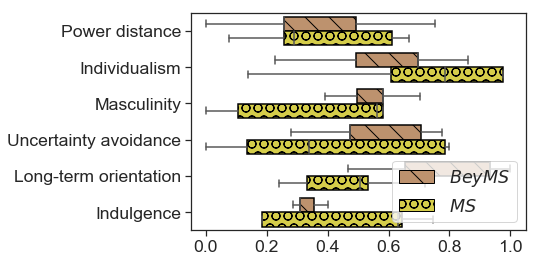

In [60]:
df = hofstede_beyms_df.append(hofstede_ms_df).drop(columns=["country"], axis=1).stack().reset_index().set_index("user_id")
df.columns = ["dimension", "value"]
df["ms"] = [uid in ms for uid in df.index]

g = sns.boxplot(data=df, x="value", y="dimension", hue="ms", showfliers=False, palette=["#ca9161", "#ece133"])
patterns = ["\\", "O"]
for hatch, patch in zip_longest_cycle(patterns, g.artists):
    patch.set_hatch(hatch)

for patch in g.artists:
    patch.set_edgecolor("black")

colors = [to_hex(patch.get_facecolor()) for patch in g.artists]
beyms_patch = mpatches.Patch(facecolor=colors[0], hatch="\\", edgecolor="black")
ms_patch = mpatches.Patch(facecolor=colors[1], hatch="O", edgecolor="black")
plt.legend(loc="lower right", handles=[beyms_patch, ms_patch])
g.legend_.set_title("")
new_labels = [r"$BeyMS$", r"$MS$"]
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)

    
plt.ylabel("")
plt.xlabel("")
plt.grid(False)

# World Happiness Report

In [61]:
def get_country_code(country_name):
    country = pycountry.countries.get(name=country_name)#.alpha_2
    if country:
        return country.alpha_2
    else:
        return np.nan

In [62]:
whr_df = pd.read_csv("data/world_happiness_report_2018.tsv", sep="\t")
whr_df["country"] = whr_df["country"].apply(lambda country: get_country_code(country))
whr_df = whr_df[whr_df.columns[:9]].dropna()
whr_df.columns = ["country", "year", "Happiness", "GDP", "Social Support", "Healthy life expectancy", "Freedom", "Generosity", "Perception of corruption"]
whr_df = whr_df.sort_values("year", ascending=False).groupby("country").head(1).set_index("country").sort_index()
whr_df.drop(columns=["year"], axis=1, inplace=True)
whr_df = pd.DataFrame(data=MinMaxScaler().fit_transform(whr_df), index=whr_df.index, columns=whr_df.columns)
whr_df.head()

,Happiness,GDP,Social Support,Healthy life expectancy,Freedom,Generosity,Perception of corruption
country,,,,,,,
AE,0.865251,0.863462,0.918722,0.742391,0.824074,0.353162,0.246942
AF,0.000000,0.189817,0.296638,0.262565,0.085926,0.205734,1.000000
AL,0.385803,0.558040,0.513642,0.787601,0.614227,0.282670,0.901660
AM,0.317177,0.492806,0.602660,0.664261,0.391650,0.177828,0.887270
AO,0.221030,0.436473,0.686451,0.266372,0.000000,0.150039,0.848808


In [63]:
whr_beyms_df = users_df.loc[beyms_in_top_countries].merge(whr_df, left_on="country", right_index=True)
whr_ms_df = users_df.loc[ms_in_top_countries].merge(whr_df, left_on="country", right_index=True)

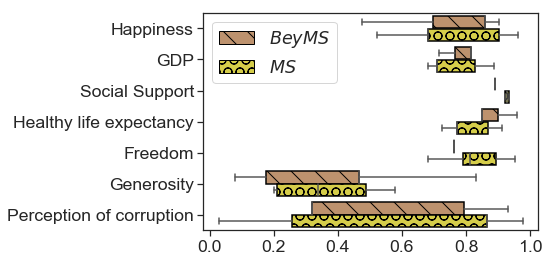

In [65]:
df = whr_beyms_df.append(whr_ms_df).drop(columns=["country"], axis=1).stack().reset_index().set_index("user_id")
df.columns = ["dimension", "value"]
df["ms"] = [uid in ms for uid in df.index]

g = sns.boxplot(data=df, x="value", y="dimension", hue="ms", showfliers=False, palette=["#ca9161", "#ece133"])
patterns = ["\\", "O"]
for hatch, patch in zip_longest_cycle(patterns, g.artists):
    patch.set_hatch(hatch)
    
for patch in g.artists:
    patch.set_edgecolor("black")
    
colors = [to_hex(patch.get_facecolor()) for patch in g.artists]
beyms_patch = mpatches.Patch(facecolor=colors[0], hatch="\\", edgecolor="black")
ms_patch = mpatches.Patch(facecolor=colors[1], hatch="O", edgecolor="black")
plt.legend(loc="upper left", handles=[beyms_patch, ms_patch])
g.legend_.set_title("")
new_labels = [r"$BeyMS$", r"$MS$"]
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)
    
plt.ylabel("")
plt.xlabel("")
plt.grid(False)

# Save datasets

In [ ]:
user_groups_df.to_csv("data/user_groups.csv")